# Counterfactual Exmplanations implementation notebook

### Preliminary stage:
- prepare data (dataloader for one point)
- prepare model (load from checkpoint)

#### Prepare data

In [185]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import random

data = pd.read_csv('../data/processed/validation.csv').drop(columns=['Unnamed: 0'])

data = data[data['loan_status'] == 1]
X = data.drop(columns=['loan_status'])
y = data['loan_status']

numerical_cols = [
   'person_age','person_income','person_emp_length','loan_amnt',
   'loan_int_rate','loan_percent_income','cb_person_cred_hist_length'
]
all_cols = list(X.columns)

In [186]:
random_idx = random.choice(range(data.shape[0]))
print(f'selected random point from negative class index: {random_idx}')

selected random point from negative class index: 713


In [187]:
X_tensor = torch.tensor(X.iloc[random_idx].values, dtype=torch.float)
y_tensor = torch.tensor(y.iloc[random_idx], dtype=torch.float)
X_tensor = X_tensor.unsqueeze(0)

#### Prepare model

In [188]:
import pytorch_lightning as pl
from torch.optim import Adam
from sklearn.metrics import recall_score

pos_weight = 2.0
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))

class CreditRiskModel (pl.LightningModule):
    def __init__(self, input_dim = 23, hidden = 64, sigmoid_threashold=0.5):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(), 
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
        self.threashold = sigmoid_threashold
    
    def forward(self, x):
        logits = self.model(x)
        return logits.squeeze(1)
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self.forward(X)
        # loss = F.binary_cross_entropy_with_logits(logits, y)
        loss = criterion(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self.forward(X)
        # loss = F.binary_cross_entropy_with_logits(logits, y)
        loss = criterion(logits, y)

        probs = torch.sigmoid(logits)
        preds = (probs > self.threashold).float()

        acc = (preds == y).float().mean()
        preds_np = preds.detach().cpu().numpy()
        y_np = y.detach().cpu().numpy()

        fnr = 1. - recall_score(y_np, preds_np)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        self.log('val_fnr', fnr, on_epoch=True, prog_bar=True)

        return loss
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)
    

ckpt_path = '../models/model/lightning_logs/credit_risk_model/version_13/checkpoints/epoch=79-step=3600.ckpt'
params_path= '../models/model/lightning_logs/credit_risk_model/version_13/hparams.yaml'
model = CreditRiskModel.load_from_checkpoint(ckpt_path, hparams_file=params_path)
model, model.device

(CreditRiskModel(
   (model): Sequential(
     (0): Linear(in_features=23, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): ReLU()
     (4): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 device(type='mps', index=0))

### Vanilla counterfactuals

The basic idea is:

1. We have a **trained model** $f$ that maps inputs $\mathbf{x}$ (the borrower’s attributes) to a **probability** of default (or a logit).  
2. We want to find a **counterfactual** $\mathbf{x}'$ such that the model’s prediction changes from the original class (e.g., “default”) to the **desired class** (e.g., “non-default”), while staying as **close** as possible to the original $\mathbf{x}$.

This is often framed as **optimization**:

$$
\min_{\mathbf{x}'} \; d(\mathbf{x}, \mathbf{x}') + \lambda \,\mathcal{L}\bigl(f(\mathbf{x}'), c\bigr),
$$

where:

- $d(\mathbf{x}, \mathbf{x}')$ is a **distance** measure (L1, L2, etc.) that encourages $\mathbf{x}'$ to remain similar to $\mathbf{x}$.  
- $\mathcal{L}(f(\mathbf{x}'), c)$ is a **classification loss** that forces the model’s prediction for $\mathbf{x}'$ to be the **target class** $c$.  
- $\lambda$ balances how strongly we weigh prediction accuracy vs. closeness.

> **Note**: This is a simplified gradient-based approach inspired by **Wachter et al. (2018)**.

In [189]:
def generate_counterfactual(
        model,
        x_original,
        target_label=0,    # 0 for "non-default", 1 for "default"
        lambda_param=1.0,  # trade-off coefficient between distance & classification loss
        lr=0.01,           # learning rate for gradient descent
        max_steps=500,     # max optimization steps
        distance_metric='l2' ):
    x_original = x_original.to(model.device).detach()
    x_cf = x_original.clone().requires_grad_(True)
    optimizer = Adam([x_cf], lr=lr)

    for step in range(max_steps):
        optimizer.zero_grad()

        # Calculate distance: encourage counterfactual to be close to original
        if distance_metric == 'l2':
            distance = torch.norm(x_cf - x_original, p=2)
        else : # use 'l1'
            distance = torch.norm(torch.norm(x_cf - x_original, p=1))
        
        # Calculate classification loss of the cf from the model prediction
        logits = model.forward(x_cf)
        label_tensor = torch.tensor([float(target_label)]).to(x_cf.device)

        # possible dimension problems...
        bce_loss = F.binary_cross_entropy_with_logits(logits, label_tensor)

        #Calculate main formula of the method
        loss = distance + lambda_param * bce_loss

        loss.backward()
        optimizer.step()

    return x_cf.detach().cpu()

#### Explanation

1. **`x_cf`** is the **counterfactual** variable we’re optimizing. It starts as a copy of $\mathbf{x}$.  
2. We define an **Adam** optimizer with `x_cf` as its “parameter.” Each step does `loss.backward()` on `x_cf`.  
3. **Distance**:  
   - `distance = torch.norm(x_cf - x_original, p=2)` for **L2**.  
   - You could switch to **p=1** for **L1** or a custom distance.  
4. **Classification loss**: We want the model’s prediction for `x_cf` to have the probability of the positive class = `target_label`. We treat this as a binary cross-entropy objective, so if `target_label=0`, it tries to push logits negative; if `1`, it tries to push them positive.  
5. **`loss = distance + lambda_param * bce_loss`**: We combine them, so the final solution tries to both “flip” the prediction and remain close to the original.  
6. Return `x_cf.detach()` at the end.

In [190]:
x_cf = generate_counterfactual(
    model=model,
    x_original=X_tensor,
    target_label=0,
    lambda_param=0.5,
    lr=0.01,
    max_steps=500,
    distance_metric='l2'
)

print("Original x:", X_tensor)
print("Counterfactual x':", x_cf)

Original x: tensor([[0.0312, 0.0069, 0.0488, 0.1594, 0.0674, 0.4280, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000]])
Counterfactual x': tensor([[ 3.5399e-02,  5.8824e-02,  5.0257e-02,  2.0245e-01,  5.7947e-02,
          3.8079e-01,  1.9936e-03,  9.9923e-01,  1.2513e-04,  4.3102e-04,
         -7.1766e-03, -4.7137e-03, -1.7670e-04,  1.0033e+00,  1.0017e+00,
          3.9685e-03, -1.6695e-03, -5.5569e-03, -9.4725e-03, -3.9067e-03,
         -3.5214e-02,  1.0016e+00,  1.5586e-04]])


### Result interpretation:
We see that our vanilla counterfactual is woking conceptually correct

Observations:
1. **Most Values Are Similar**: Many features (especially the first half) only shifted slightly – for instance, `0.1562 → 0.1606`, `0.3415 → 0.2691`, etc. These small nudges can be enough to reduce the model’s predicted probability of default if those features have higher influence.

2. **Negative Shifts**: Some features that were originally `0.0000` became slightly negative (e.g., `-0.0354`, `-0.0563`). Because we **didn’t impose any constraints** to keep them ≥0, the gradient-based optimization allowed the counterfactual to move continuously in that space. In a real credit scenario, it might make no sense to have negative values for certain features. You’d typically clamp them to valid ranges or use a custom penalty for going below zero.

3. **Small Gains Above 1**: For instance, `1.0000 → 1.0163` or `1.0000 → 1.0030`. Again, without constraints or clamping, the counterfactual can become slightly >1. If a feature is fundamentally bounded in [0,1], you’d usually clamp or project it back within [0,1] after each gradient step.

4. **Interpretation**: The underlying assumption is that by making these minor continuous changes, the model’s predicted outcome changes from “default likely” to “non-default.” In practice, you’d want to:
   - Impose **feasibility** constraints (e.g., if some fields must remain integer or within [0,1]).  
   - Possibly adjust the **distance function** or weighting $\lambda$ if changes are too scattered or too large.

### Next Steps

- **Add Constraints**: For example, clamp each feature after each gradient step so that `feature_value = feature_value.clamp(min=0.0, max=1.0)` if you know it’s a normalized ratio.  
- **Domain Logic**: If some features are strictly categorical (e.g., one-hot vectors for “rent,” “own,” etc.), you could freeze them or only allow changes among valid one-hot states.  
- **Tune $\lambda$**: Adjust the trade-off parameter so that the model modifies fewer features or flips the prediction more decisively.  


### Counterfactual exmplanations with a twist

- Some columns like `loan_purpose`, should not be included into the analysis because one takes a loan for some reason and is not interested in changing this reason just to get the loan
  - Out goal is to dive into some feature analysis and think what features should be frozen (unchanged during optimization)
- Next, we need to add some contraints to the optimizer, on how the values should be changed:
  - most of out features are OneHot encoded categorical features, so for example if `cb_person_default_on_file_Y` is set `0` -> `1`, then `cb_person_default_on_file_N` should automatically turn `1` -> `0`.
  - Also we should say that from categorical encodings the change should be discrete.

In [191]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,...,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,loan_status
count,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,...,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.0
mean,0.118944,0.022717,0.097325,0.312161,0.436917,0.323226,0.132439,1.287671,0.206285,0.150685,...,0.131346,0.246575,0.184529,0.298952,0.106366,0.019339,0.012893,0.683320,0.316680,1.0
std,0.103969,0.019156,0.092896,0.214208,0.183560,0.168896,0.150222,0.522325,0.404801,0.357886,...,0.337914,0.431191,0.388071,0.457984,0.308430,0.137770,0.112858,0.465369,0.465369,0.0
min,0.015625,0.000491,0.000000,0.014493,0.000000,0.008676,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.046875,0.012771,0.024390,0.130435,0.312921,0.178806,0.035714,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.093750,0.018666,0.073171,0.275362,0.457865,0.317238,0.071429,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0
75%,0.156250,0.027508,0.146341,0.420290,0.573034,0.445913,0.214286,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0
max,0.781250,0.294727,0.731707,1.000000,0.958427,0.919055,1.000000,3.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [192]:
print(data.columns)

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'person_home_ownership', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y',
       'loan_status'],
      dtype='object')


#### feature outline:

| **Index** | **Feature**                       | **Type**      | **Can it be changed?**                                                        | **Range / Values**        | **Notes**                                                                                                           |
|-----------|-----------------------------------|---------------|-------------------------------------------------------------------------------|---------------------------|----------------------------------------------------------------------------------------------------------------------|
| **0**     | **person_age**                    | Numerical     | **Cannot be changed**                                                         | [0, 1] (scaled)           | Represents the borrower’s age. Typically viewed as fixed (e.g., for counterfactuals, we assume one cannot “get younger”). |
| **1**     | **person_income**                 | Numerical     | **Can be changed**                                                            | [0, 1] (scaled)           | An applicant could theoretically change their declared (or actual) income or pursue higher income for a new application. |
| **2**     | **person_emp_length**             | Numerical     | **Can be changed**                                                            | [0, 1] (scaled)           | Reflects length of employment; might be interpreted as adjusting tenure or switching jobs (though not trivial).       |
| **3**     | **loan_amnt**                     | Numerical     | **Can be changed** (often negotiable)                                         | [0, 1] (scaled)           | The principal loan amount requested. In practice, one could apply for a smaller (or larger) loan.                     |
| **4**     | **loan_int_rate**                 | Numerical     | **Cannot be changed**                                                         | [0, 1] (scaled)           | Interest rate is typically set by the lender based on risk; not directly changed by the applicant.                    |
| **5**     | **loan_percent_income**           | Numerical     | **Indirectly changes if income or loan amount changes** (not directly changed) | [0, 1] (scaled)           | This ratio depends on both `person_income` and `loan_amnt`. Changing either will alter this feature automatically.     |
| **6**     | **cb_person_cred_hist_length**    | Numerical     | **Cannot be changed**                                                         | [0, 1] (scaled)           | Represents the length of credit history on the applicant’s credit bureau report—typically not alterable immediately.   |
| **7**     | **person_home_ownership**         | Categorical   | **Can be changed** (though not trivial in reality)                            | [0, 1, 2, 3] (ordinal)    | Categories usually represent: 0=RENT, 1=MORTGAGE, 2=OWN, 3=OTHER (or similar). Changing homeownership status may be complex. |
| **8**     | **loan_intent_DEBTCONSOLIDATION** | Categorical   | **Cannot be changed**                                                         | [0, 1]                     | One-hot encoding for loan intent = debt consolidation. Typically a declared purpose of the loan.                       |
| **9**     | **loan_intent_EDUCATION**         | Categorical   | **Cannot be changed**                                                         | [0, 1]                     | One-hot encoding for loan intent = education.                                                                         |
| **10**    | **loan_intent_HOMEIMPROVEMENT**   | Categorical   | **Cannot be changed**                                                         | [0, 1]                     | One-hot encoding for loan intent = home improvement.                                                                  |
| **11**    | **loan_intent_MEDICAL**           | Categorical   | **Cannot be changed**                                                         | [0, 1]                     | One-hot encoding for loan intent = medical.                                                                           |
| **12**    | **loan_intent_PERSONAL**          | Categorical   | **Cannot be changed**                                                         | [0, 1]                     | One-hot encoding for loan intent = personal.                                                                          |
| **13**    | **loan_intent_VENTURE**           | Categorical   | **Cannot be changed**                                                         | [0, 1]                     | One-hot encoding for loan intent = venture.                                                                           |
| **14**    | **loan_grade_A**                  | Categorical   | **Cannot be changed**                                                         | [0, 1]                     | One-hot encoding for a particular loan grade assigned by the lender.                                                 |
| **15**    | **loan_grade_B**                  | Categorical   | **Cannot be changed**                                                         | [0, 1]                     |                                                                                                                      |
| **16**    | **loan_grade_C**                  | Categorical   | **Cannot be changed**                                                         | [0, 1]                     |                                                                                                                      |
| **17**    | **loan_grade_D**                  | Categorical   | **Cannot be changed**                                                         | [0, 1]                     |                                                                                                                      |
| **18**    | **loan_grade_E**                  | Categorical   | **Cannot be changed**                                                         | [0, 1]                     |                                                                                                                      |
| **19**    | **loan_grade_F**                  | Categorical   | **Cannot be changed**                                                         | [0, 1]                     |                                                                                                                      |
| **20**    | **loan_grade_G**                  | Categorical   | **Cannot be changed**                                                         | [0, 1]                     |                                                                                                                      |
| **21**    | **cb_person_default_on_file_N**   | Categorical   | **Cannot be changed**                                                         | [0, 1]                     | Whether the person has a default on file (N=No).                                                                      |
| **22**    | **cb_person_default_on_file_Y**   | Categorical   | **Cannot be changed**                                                         | [0, 1]                     | Whether the person has a default on file (Y=Yes).                                                                     |

In [193]:
free_indices = [1, 2, 3, 7]
fixed_indices = [i for i in range(X_tensor.shape[1]) if i not in free_indices]

In [194]:
def generate_mask(tensor, fixed_indices):
    mask = torch.ones_like(tensor)
    for idx in fixed_indices:
        mask[0, idx] = 0.
    return mask

generate_mask(X_tensor, fixed_indices)

tensor([[0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])

In [195]:
def generate_masked_counterfactual(
        model,
        x_original,
        mask,              # a mask for the gradients to fix the non changable features
        target_label=0,    # 0 for "non-default", 1 for "default"
        lambda_param=1.0,  # trade-off coefficient between distance & classification loss
        lr=0.01,           # learning rate for gradient descent
        max_steps=500,     # max optimization steps
        distance_metric='l2' ):

    x_original = x_original.to(model.device).detach()
    x_cf = x_original.clone().requires_grad_(True)
    mask = mask.to(model.device)
    optimizer = Adam([x_cf], lr=lr)

    for step in range(max_steps):
        optimizer.zero_grad()

        # Calculate distance: encourage counterfactual to be close to original
        if distance_metric == 'l2':
            distance = torch.norm(x_cf - x_original, p=2)
        else : # use 'l1'
            distance = torch.norm(torch.norm(x_cf - x_original, p=1))
        
        # Calculate classification loss of the cf from the model prediction
        logits = model.forward(x_cf)
        label_tensor = torch.tensor([float(target_label)]).to(x_cf.device)
        bce_loss = F.binary_cross_entropy_with_logits(logits, label_tensor)

        #Calculate main formula of the method
        loss = distance + lambda_param * bce_loss

        loss.backward()
        # Zero out gradients on frozen features
        with torch.no_grad():
            x_cf.grad *= mask
        optimizer.step()

    return x_cf.detach().cpu()

In [196]:
mask = generate_mask(X_tensor, fixed_indices)

In [221]:
import matplotlib.pyplot as plt

def generate_counterfactual_visuals(x_original, x_cf):
    x_orig_np = x_original.squeeze().detach().cpu().numpy()
    x_cf_np   = x_cf.squeeze().detach().cpu().numpy()

    comparison_df = pd.DataFrame({
        'Feature': all_cols,
        'Original': x_orig_np,
        'Counterfactual': x_cf_np
    })
    comparison_df['delta'] = comparison_df['Counterfactual'] - comparison_df['Original']
    
    print(comparison_df)

    deltas = comparison_df['delta'].values[:7]

    # Make it 2D so imshow can display it as a row
    data_for_heatmap = np.expand_dims(deltas, axis=0) 

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(7, 5))
    max_abs_delta = np.abs(deltas).max()

    # Plot the heatmap
    cax = ax.imshow(
        data_for_heatmap,
        cmap='coolwarm',          # diverging palette
        aspect='auto', 
        vmin=-max_abs_delta,      # symmetrical bounds
        vmax= max_abs_delta
    )

    # No y-axis tick labels (only 1 row)
    ax.set_yticks([])
    # Feature names along x-axis
    ax.set_xticks(range(len(deltas)))
    ax.set_xticklabels(all_cols[:7], rotation=45, ha='right')

    ax.set_title('Heatmap of Delta (clipped only to numerical columns)')
    fig.colorbar(cax, ax=ax, fraction=0.025, pad=0.04)
    plt.tight_layout()
    plt.show()

    return comparison_df
    

                          Feature  Original  Counterfactual     delta
0                      person_age  0.031250        0.031250  0.000000
1                   person_income  0.006877        0.112425  0.105548
2               person_emp_length  0.048780        0.049547  0.000767
3                       loan_amnt  0.159420        0.222083  0.062663
4                   loan_int_rate  0.067416        0.067416  0.000000
5             loan_percent_income  0.428011        0.428011  0.000000
6      cb_person_cred_hist_length  0.000000        0.000000  0.000000
7           person_home_ownership  1.000000        1.017331  0.017331
8   loan_intent_DEBTCONSOLIDATION  0.000000        0.000000  0.000000
9           loan_intent_EDUCATION  0.000000        0.000000  0.000000
10    loan_intent_HOMEIMPROVEMENT  0.000000        0.000000  0.000000
11            loan_intent_MEDICAL  0.000000        0.000000  0.000000
12           loan_intent_PERSONAL  0.000000        0.000000  0.000000
13            loan_i

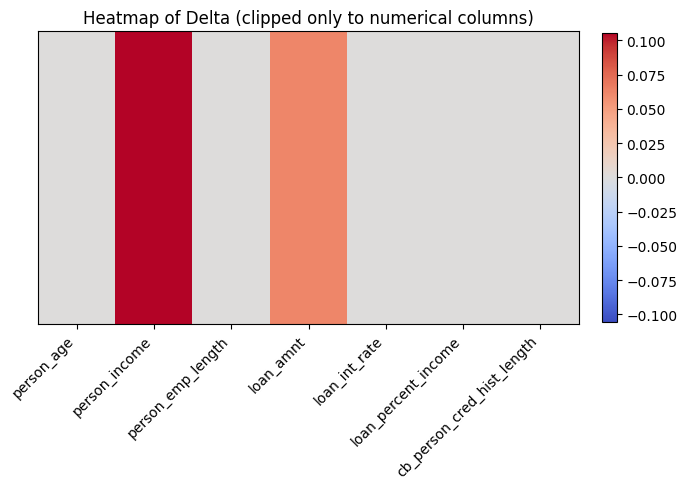

In [222]:
x_cf = generate_masked_counterfactual(
    model=model,
    mask=mask,
    x_original=X_tensor,
    target_label=0,
    lambda_param=0.5,
    lr=0.01,
    max_steps=500,
    distance_metric='l2'
)
comparison_df = generate_counterfactual_visuals(X_tensor, x_cf)


Now we would like to further complexify or couterfactuals, because we have a computation feature called `loan_percent_income`

`loan_percent_income` = `loan_amnt` / `person_income`

this means if we modify either of those 2 featues the loan persent income feature will also change, right now it is freezed, but we need to incorporate it's recalculation every step of the of the optimization process, however it willl still be freezed. So we just recalculate it to make the model prediction more accurate, rather than optimize it directly. 

But firstly we need to check whether the calculation formula is correct:
```py
assert np.allclose(data['loan_amnt'] / data['person_income'], data['loan_percent_income'])
```

this gave us

``` txt
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
Cell In[71], line 1
----> 1 assert np.allclose(data['loan_amnt'] / data['person_income'], data['loan_percent_income'])
```

#### Why the Original Relationship Breaks

We have:

$$
\text{loan\_percent\_income} \stackrel{\text{ideal}}{=} \frac{\text{loan\_amnt}}{\text{person\_income}},
$$

but once we apply a **MinMaxScaler** to each feature independently, each is scaled to $[0,1]$ using its own $\min$ and $\max$. Concretely:

$$
\text{scaled\_amnt} 
= \frac{\text{loan\_amnt} - \min(\text{amnt})}{\max(\text{amnt}) - \min(\text{amnt})},
\quad
\text{scaled\_income} 
= \frac{\text{person\_income} - \min(\text{income})}{\max(\text{income}) - \min(\text{income})},
\quad \dots
$$

Therefore, in **scaled** space, the ratio

$$
\frac{\text{scaled\_amnt}}{\text{scaled\_income}}
$$

no longer matches the scaled value of $\text{loan\_percent\_income}$. Hence, the direct relationship $\text{loan\_amnt} / \text{person\_income}$ is **broken** by independent scaling.

---

#### Recomputing the True Ratio

If we **modify** `loan_amnt` or `person_income` during a process like counterfactual optimization, we likely want **`loan_percent_income`** to reflect the **true** ratio in original domain:

$$
\text{orig\_ratio} 
= \frac{\text{orig\_loan\_amnt}}{\text{orig\_person\_income}}.
$$

However, because the model expects scaled inputs, we must perform these steps:

1. **Inverse-transform** the two columns of interest $\text{loan\_amnt}$ and $\text{person\_income}$ from $[0,1]$ back to their original domain.
2. Compute $\text{new\_ratio} = \frac{\text{orig\_loan\_amnt}}{\text{orig\_person\_income}}$.
3. **Re-scale** only that ratio column so it again lies in $[0,1]$.
4. Inject the new scaled ratio back into the feature vector.

---

#### The Partial “Injection” Approach

A naive method might inverse-transform **all** numeric columns, recalc the ratio, and re-transform everything. That can introduce minor float changes to columns we do not wish to alter (like `person_age`). Instead, we do a **partial** approach, often called “injection”:

1. **Extract** the scaled columns for **A** = `person_income` and **B** = `loan_amnt`.  
2. **Inverse** them individually:

   $$
   \text{origA}
   = (\text{scaledA}) \times (\max(A) - \min(A)) 
      \;+\; \min(A),
   \quad
   \text{origB}
   = (\text{scaledB}) \times (\max(B) - \min(B)) 
      \;+\; \min(B).
   $$

3. **Compute** $C$ in the original domain, e.g. for a ratio:
   $$
   C = 
   \begin{cases}
     \frac{B}{A}, & A \neq 0, \\
     0.0, & A = 0.
   \end{cases}
   $$
4. **Scale** only $C$ back to $[0,1]$:

   $$
   \text{scaledC}
   = \frac{\text{origC} - \min(C)}{\max(C) - \min(C)},
   \quad
   \text{(then optionally clamp in [0,1])}.
   $$

5. **Inject** $\text{scaledC}$ back into the feature vector at the index of `loan_percent_income`. We do **not** alter the scaled $\text{loan\_amnt}$ or $\text{person\_income}$, leaving them exactly as is if we haven’t otherwise changed them.

Thus, if we are only re-calculating `loan_percent_income`, no other feature experiences a float round-trip. This is beneficial in a **counterfactual** scenario, where we typically want fine control over which columns truly update.


In [199]:
def form_recalc_dict(
        A_name, B_name, C_name, ratio_func, scaler):
    """
    Create a dictionary of parameters needed to recalculate a scaled feature C
    based on a relationship between two other scaled features A and B 
    (e.g., C = B / A in the original domain).

    Args:
        A_name (str): The column name for component A (e.g., 'person_income').
        B_name (str): The column name for component B (e.g., 'loan_amnt').
        C_name (str): The column name for component C (e.g., 'loan_percent_income').
        ratio_func (callable): A function ratio_func(a, b) -> float, defining how
            to compute the original-domain value of C from A and B.
        scaler (MinMaxScaler): A fitted MinMaxScaler that was trained on the 
            numeric columns, used for inverse transforming A/B and re-scaling C.

    Returns:
        dict: A dictionary containing the global/local indices for A, B, C,
              plus the calculation function and the scaler.
              This dictionary is meant to be passed to `recalculate_scaled()`.
    
    Notes:
        - Assumes you have global variables `all_cols` and `numerical_cols`
          which define the order of the full feature set and the numeric subset, 
          respectively.
    """
    idxA_global = all_cols.index(A_name)
    idxB_global = all_cols.index(B_name)
    idxC_global = all_cols.index(C_name)

    idxA_local = numerical_cols.index(A_name)
    idxB_local = numerical_cols.index(B_name)   
    idxC_local = numerical_cols.index(C_name)
    return {
        'global': [idxA_global, idxB_global, idxC_global],
        'local': [idxA_local, idxB_local, idxC_local],
        'calc_func': ratio_func,
        'scaler': scaler
        }

In [200]:
import torch
from sklearn.preprocessing import MinMaxScaler

def recalculate_scaled(
    x_scaled_full: torch.Tensor,
    recacl_param_dict: dict
) -> torch.Tensor:
    """
    Update one scaled feature (C) in x_scaled_full based on a user-defined
    relationship involving two other scaled features (A and B). Only the 
    feature C column is changed; all other values remain identical.

    Args:
        x_scaled_full (torch.Tensor): A tensor of shape [1, num_features],
            containing scaled values for the entire feature vector.
        recacl_param_dict (dict): A dictionary returned by `form_recalc_dict()`, 
            containing:
            - 'global': list of [idxA_global, idxB_global, idxC_global] 
              for the feature indices in the full input.
            - 'local': list of [idxA_local, idxB_local, idxC_local] 
              for their indices in the numeric array used by the scaler.
            - 'calc_func': a function calc_func(a, b) -> c in the original domain.
            - 'scaler': the fitted MinMaxScaler used to do partial inverse.
    
    Returns:
        torch.Tensor: A new tensor of shape [1, num_features], where only
            the feature C column has been recalculated and re-scaled 
            based on the relationship between A and B in the original domain.

    Notes:
        - The function does not alter A or B themselves, nor any other columns.
        - This approach ensures only the target column C is re-scaled.
        - The user can define any function for `calc_func(a, b)` to represent 
          the original-domain relationship (e.g., c = b / a).
    """
    device = x_scaled_full.device
    dtype  = x_scaled_full.dtype

    # Unpack recalculation params
    idxA_global, idxB_global, idxC_global = recacl_param_dict['global']
    idxA_local, idxB_local, idxC_local = recacl_param_dict['local']
    calc_func = recacl_param_dict['calc_func']
    scaler = recacl_param_dict['scaler']
    
    x_cpu = x_scaled_full.clone().detach().cpu().numpy()
    
    scaledA = x_cpu[0, idxA_global]
    scaledB = x_cpu[0, idxB_global]
    
    # Retrieve the min/max from scaler for local indices
    minA = scaler.data_min_[idxA_local]
    maxA = scaler.data_max_[idxA_local]
    minB = scaler.data_min_[idxB_local]
    maxB = scaler.data_max_[idxB_local]
    minC = scaler.data_min_[idxC_local]
    maxC = scaler.data_max_[idxC_local]

    # Convert scaled -> original domain
    #    orig_val = scaled_val * (max - min) + min
    origA = scaledA * (maxA - minA) + minA
    origB = scaledB * (maxB - minB) + minB

    # Compute new C in the original domain
    origC = calc_func(origA, origB)

    # Re-scale that new C to [0,1]
    #    scaledC = (origC - minC) / (maxC - minC)
    denomC = (maxC - minC)
    if denomC == 0:
        scaledC = 0.0
    else:
        scaledC = (origC - minC) / denomC
    # optional clamp
    scaledC = max(0.0, min(1.0, scaledC))

    # Inject new scaledC back
    x_cpu[0, idxC_global] = scaledC

    x_updated = torch.tensor(x_cpu, device=device, dtype=dtype)
    return x_updated


In [201]:
# Example usage
import joblib

scaler_path = '../models/scaler/scaler.pkl'
scaler = joblib.load(scaler_path)

def ratio_func(a, b):
    return 0.0 if a == 0.0 else (b / a)

A_name = 'person_income'
B_name = 'loan_amnt'
C_name = 'loan_percent_income'


recalc_params = form_recalc_dict(A_name, B_name, C_name, ratio_func, scaler)

X_recalc = recalculate_scaled(X_tensor, recalc_params)


In [202]:
assert torch.allclose(X_tensor, X_recalc, rtol=1e-05, atol=1e-08)

If we comapare now the recalculated and original, nothing should have changed because the precomputed feature on the initial stage is correct (we computed it manually duraing data processing)

Now we finally can incorporate this into our counterfactual explanation generaton

In case we have multiple recalculations, we need to build the sort of matrix of feature relationships:
```txt
[
    [A_name, B_name, C_name, calc_func1],
    [D_name, E_name, F_name, calc_func2],
    [...],
    ...
]
```
> **Note:** here we assume that scaler for numerical features is all the same.

In [203]:
recalc_params_matrix = [['person_income', 'loan_amnt', 'loan_percent_income', ratio_func]] # in our case only one row in the matrix

We want to put our recalculations after the optimizer step(tweeking the features), because during the next iteration the recalculated feature would effect the prediction, but then it is masked, so it does not directly affect the optimization.

Step-by-Step Logic

1. **Initialization**:  
   - We have `x_original` shaped `[1, features]`.  
   - We clone it into `x_cf` with `requires_grad_(True)`.  
   - Our **mask** is a vector `[features]` with 1.0 for columns we allow to move, and 0.0 for columns we want to freeze or handle externally (like $C$).

2. **Optimizer Loop**:

   1. **Forward pass** to compute:
      - A **distance** term: $\text{x\_cf} - \text{x\_original}$.  
      - A **classification** loss: $\mathrm{BCEWithLogitsLoss}(\mathrm{logits}(x_{cf}), \text{target\_label})$.  
      - **Combined**: $\mathrm{loss} = \mathrm{distance} + \lambda \times \mathrm{bce\_loss}$.

   2. **backward()**: 
      - PyTorch computes gradients for **all** columns in `x_cf`.
      - We then **zero out** the gradient for masked columns. Specifically, `x_cf.grad *= mask`. 
        - This ensures the optimizer does **not** modify $C$ directly.

   3. **optimizer.step()**:
      - Only columns with non-zero gradient (mask=1) get updated.  
      - This moves $A$ and $B$ (and possibly other free columns).

   4. **Manual injection of $C$**:
      - After the step, we recompute $C$ from the newly updated $A$ and $B$.  
      - We do this by **partial inverse** (to get original domain $A, B$) $\to$ compute new $C$ $\to$ scale new $C$ $\to$ overwrite the “C” slot in `x_cf`.  
      - Because `x_cf` has `requires_grad_(True)`, we must do this in a `with torch.no_grad()` block or break the gradient. But that’s intentional—we do **not** want the model to backprop through the formula for $C$.

In [216]:
def generate_masked_counterfactual_with_recalculation(
        model,
        x_original,
        mask,                 # a mask for the gradients to fix the non changable features
        scaler,               # scaler we used to scale original data during processing
        recalc_params_matrix, # matrix of feature relations needed recalculation 
        target_label=0,       # 0 for "non-default", 1 for "default"
        lambda_param=1.0,     # trade-off coefficient between distance & classification loss
        lr=0.01,              # learning rate for gradient descent
        max_steps=500,        # max optimization steps
        distance_metric='l2' ):
    
    """
    Generates a counterfactual 'x_cf' by optimizing x_original under a masked gradient approach.
    After each gradient step, partial re-scaling is applied to update certain feature relationships
    (e.g. loan_percent_income = loan_amnt / person_income).

    Args:
        model (nn.Module): A trained PyTorch model accepting scaled inputs, returning logits.
        x_original (torch.Tensor): shape [1, num_features], scaled input for the original sample.
        mask (torch.Tensor): shape [num_features], with 1.0 where features are allowed to change,
            0.0 for frozen features. We'll multiply the gradient by this mask before step.
        scaler (MinMaxScaler): Fitted scaler for numeric features, used in partial inverse transforms.
        recalc_params_matrix (list): A list of relationships to recalc, each item is:
            [A_name, B_name, C_name, calc_func]
            where calc_func(a, b) => new c in the original domain.
        target_label (int): The binary label we want to achieve in the model output.
        lambda_param (float): Weight of classification loss vs. distance to original.
        lr (float): Learning rate for Adam.
        max_steps (int): Number of gradient updates.
        distance_metric (str): 'l2' or 'l1' for the distance component.

    Returns:
        x_cf (torch.Tensor): shape [1, num_features], the final counterfactual (on CPU).
    """

    x_original = x_original.to(model.device).detach()
    x_cf = x_original.clone().requires_grad_(True)
    mask = mask.to(model.device)
    optimizer = Adam([x_cf], lr=lr)

    for step in range(max_steps):
        optimizer.zero_grad()

        # Calculate distance: encourage counterfactual to be close to original
        if distance_metric == 'l2':
            distance = torch.norm(x_cf - x_original, p=2)
        else : # use 'l1'
            distance = torch.norm(torch.norm(x_cf - x_original, p=1))
        
        # Calculate classification loss of the cf from the model prediction
        logits = model.forward(x_cf)
        label_tensor = torch.tensor([float(target_label)]).to(x_cf.device)
        bce_loss = F.binary_cross_entropy_with_logits(logits, label_tensor)

        #Calculate main formula of the method
        loss = distance + lambda_param * bce_loss

        loss.backward()
        # Zero out gradients on frozen features
        with torch.no_grad():
            x_cf.grad *= mask
        optimizer.step()

        # Recompute relationships after the optimization step
        with torch.no_grad():
            # Iterate through relationship matrix to do the recalculation
            for rel in recalc_params_matrix:
                A, B, C, func = rel
                param_dict = form_recalc_dict(A, B, C, func, scaler)
                x_cf_updated = recalculate_scaled(x_cf, param_dict)
                x_cf.copy_(x_cf_updated)

    return x_cf.detach().cpu()

In [217]:
mask = generate_mask(X_tensor, fixed_indices)

                          Feature  Original  Counterfactual     delta
0                      person_age  0.031250        0.031250  0.000000
1                   person_income  0.006877        0.018195  0.011318
2               person_emp_length  0.048780        0.047478 -0.001303
3                       loan_amnt  0.159420        0.170310  0.010890
4                   loan_int_rate  0.067416        0.067416  0.000000
5             loan_percent_income  0.428011        0.198590 -0.229420
6      cb_person_cred_hist_length  0.000000        0.000000  0.000000
7           person_home_ownership  1.000000        0.998743 -0.001257
8   loan_intent_DEBTCONSOLIDATION  0.000000        0.000000  0.000000
9           loan_intent_EDUCATION  0.000000        0.000000  0.000000
10    loan_intent_HOMEIMPROVEMENT  0.000000        0.000000  0.000000
11            loan_intent_MEDICAL  0.000000        0.000000  0.000000
12           loan_intent_PERSONAL  0.000000        0.000000  0.000000
13            loan_i

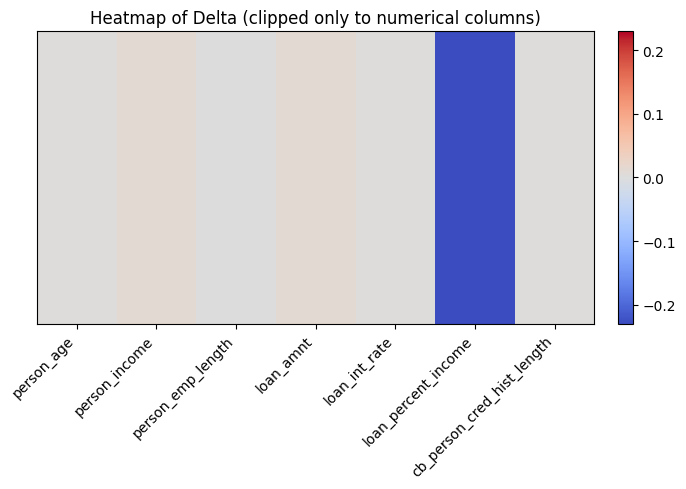

In [224]:
x_cf = generate_masked_counterfactual_with_recalculation(
    model=model,
    mask=mask,
    x_original=X_tensor,
    scaler=scaler,
    recalc_params_matrix=recalc_params_matrix,
    target_label=0,
    lambda_param=0.5,
    lr=0.01,
    max_steps=500,
    distance_metric='l2'
)
comparison_df = generate_counterfactual_visuals(X_tensor, x_cf)